In [ ]:
# ================================
# Early Disease Detection (Heart)
# ================================

In [2]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
)
from sklearn.inspection import permutation_importance
import joblib

In [6]:
# 2) Load data
# Replace with your actual file if different
df = pd.read_csv("C:\\Users\\ASUS\\Downloads\\Data_file - data_file_Project C.csv")

print("Shape:", df.shape)
print(df.head())
print(df.dtypes)

Shape: (70000, 16)
         date    country  id  active    age  alco  ap_hi  ap_lo  cholesterol  \
0  03-05-2021  Indonesia   0       1  18393     0    110     80            1   
1  05-08-2021   Malaysia   1       1  20228     0    140     90            3   
2  13-11-2022  Indonesia   2       0  18857     0    130     70            3   
3  31-10-2018  Singapore   3       1  17623     0    150    100            1   
4  25-09-2020  Singapore   4       0  17474     0    100     60            1   

   gender  gluc  height  occupation  smoke  weight  disease  
0       2     1     168   Architect      0    62.0        0  
1       1     1     156  Accountant      0    85.0        1  
2       1     1     165        Chef      0    64.0        1  
3       2     1     169      Lawyer      0    82.0        1  
4       1     1     156   Architect      0    56.0        0  
date            object
country         object
id               int64
active           int64
age              int64
alco         

In [8]:
# 3) Basic audit
target_col = "disease"  # change here if needed
assert target_col in df.columns, f"Target '{target_col}' not found!"

# Drop duplicates if any
df = df.drop_duplicates().reset_index(drop=True)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nTarget balance:")
print(df[target_col].value_counts(normalize=True).rename("proportion"))


Missing values per column:
date           0
country        0
id             0
active         0
age            0
alco           0
ap_hi          0
ap_lo          0
cholesterol    0
gender         0
gluc           0
height         0
occupation     0
smoke          0
weight         0
disease        0
dtype: int64

Target balance:
disease
0    0.5003
1    0.4997
Name: proportion, dtype: float64


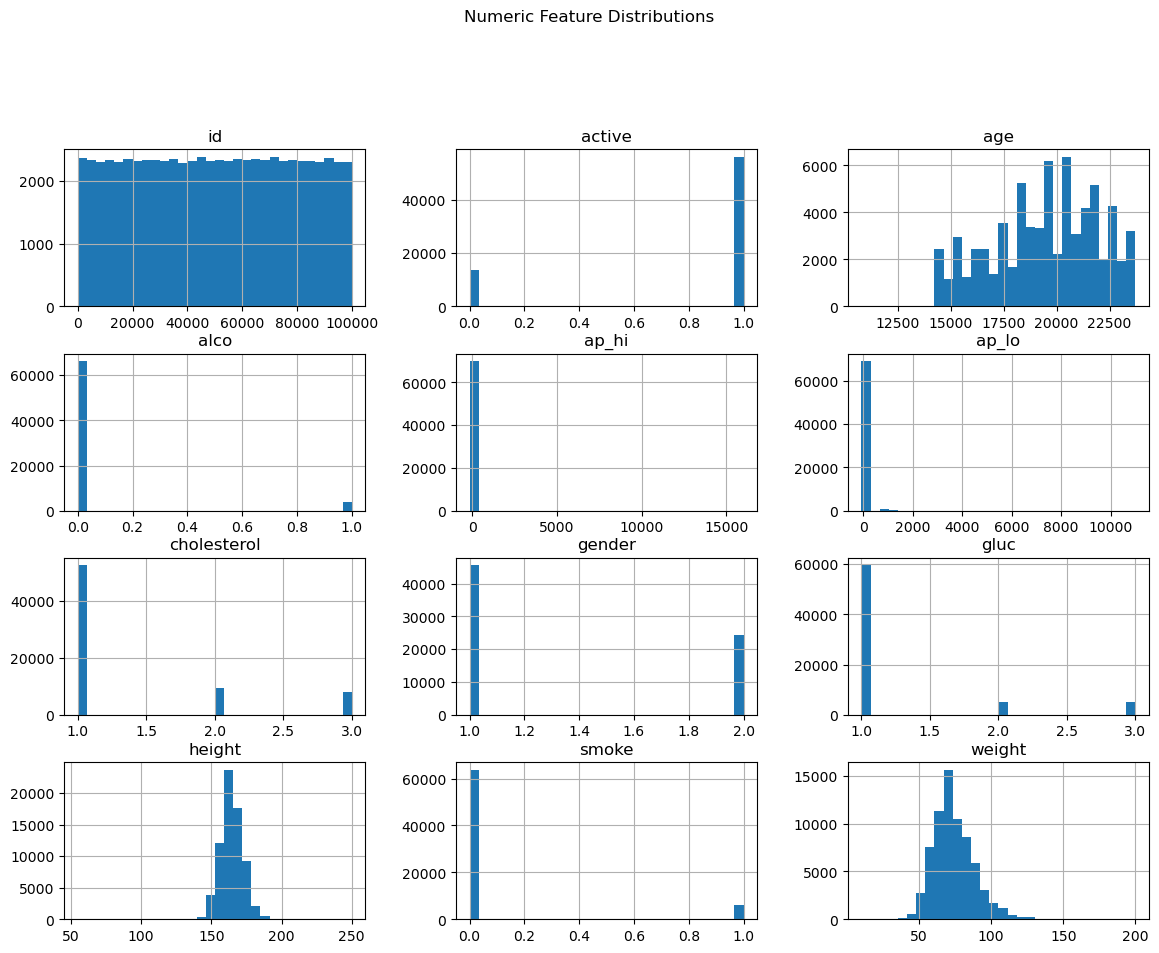

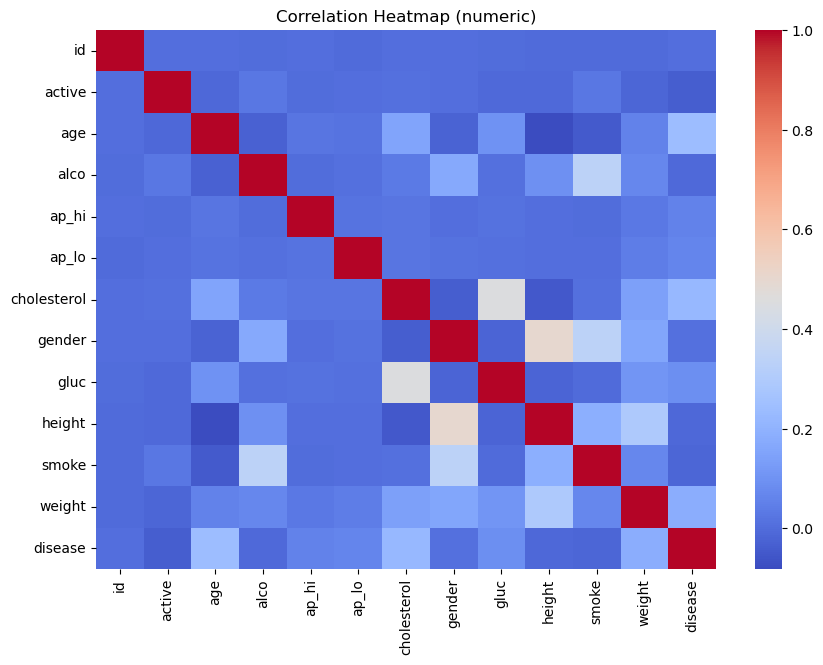

In [12]:
# 4) EDA (quick, safe plots)
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col, errors="ignore")
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# Distributions
_ = df[numeric_cols].hist(bins=30, figsize=(14, 10))
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.show()

# Correlation heatmap (numeric only)
if len(numeric_cols) > 1:
    plt.figure(figsize=(10, 7))
    sns.heatmap(df[numeric_cols.tolist() + [target_col]].corr(), annot=False, cmap="coolwarm")
    plt.title("Correlation Heatmap (numeric)")
    plt.show()

In [14]:
# 5) Split
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
# 6) Preprocessing
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat", categorical_pipe, categorical_features)
    ]
)

In [18]:
# 7) Baseline
baseline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)
base_proba = getattr(baseline.named_steps["clf"], "predict_proba", lambda X: None)

print("\n=== Baseline (Dummy) ===")
print("Accuracy:", accuracy_score(y_test, base_pred))
print("Precision:", precision_score(y_test, base_pred, zero_division=0))
print("Recall:", recall_score(y_test, base_pred, zero_division=0))
print("F1:", f1_score(y_test, base_pred, zero_division=0))


=== Baseline (Dummy) ===
Accuracy: 0.5002857142857143
Precision: 0.0
Recall: 0.0
F1: 0.0


In [ ]:
# 8) Candidate models + Grids
pipe_log = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

pipe_svm = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
])

pipe_rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid_log = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"]
}

param_grid_svm = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"]
}

param_grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

models = [
    ("LogisticRegression", pipe_log, param_grid_log),
    ("SVM_RBF", pipe_svm, param_grid_svm),
    ("RandomForest", pipe_rf, param_grid_rf)
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(name, model, X_test, y_test, threshold=None):
    proba = model.predict_proba(X_test)[:, 1]
    if threshold is None:
        pred = (proba >= 0.5).astype(int)
    else:
        pred = (proba >= threshold).astype(int)

    print(f"\n=== {name} (threshold={threshold if threshold else 0.5}) ===")
    print("Accuracy :", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred, zero_division=0))
    print("Recall   :", recall_score(y_test, pred, zero_division=0))
    print("F1       :", f1_score(y_test, pred, zero_division=0))
    print("ROC-AUC  :", roc_auc_score(y_test, proba))
    print("PR-AUC   :", average_precision_score(y_test, proba))
    print("\nClassification Report:\n", classification_report(y_test, pred, zero_division=0))

    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f"ROC Curve - {name}"); plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, proba)
    plt.title(f"Precision-Recall Curve - {name}"); plt.show()

best_models = {}
for name, pipe, grid in models:
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)
    print(f"\n>>> {name} best params:", gs.best_params_)
    print(f">>> {name} best CV ROC-AUC:", gs.best_score_)
    best_models[name] = gs.best_estimator_


>>> LogisticRegression best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
>>> LogisticRegression best CV ROC-AUC: 0.7758131360513165


In [ ]:
# 9) Compare on test (default threshold 0.5)
for name, mdl in best_models.items():
    evaluate(name, mdl, X_test, y_test, threshold=None)
